Notebook 10: Q-Learning
=======================

## Goals for learning
In this assignment, we will:
1) Perform a deep-dive into **Reinforcement Learning** (RL).
2) Gain experience working with the off-the-shelf [Gymnasium](https://gymnasium.farama.org/) library for RL.
3) Experiment with the effects the $\epsilon$ hyperparameter on the **$\epsilon$-greedy** algorithm.
4) Implement a **Q-Learning** algorithm.

## Instructions
* Read through the notebook.
* Answer any plain text questions (replace cell content, "YOUR RESPONSE HERE", with your response).
* Insert your code within the code blocks marked with the comments "# START your code here" and "# STOP your code here".
* Do not import any libraries other than those that have been imported already.
* Do not use any "Generative AI" tools or assistants in the creation of your solutions.
* Run all cells to make sure your code works and you see reasonable results.
    * All code cells should have output indicating the results of the last run when the notebook is submitted.
    * If there are errors, or if a code cell does not have output as submittted, points will be deducted.

## Submission details
* Due: Monday 12/01, 11:59 PM
* [Submission instructions](https://www.cs.oswego.edu/~agraci2/csc461/submission_instructions.html)

## Notebook Premise
You want to teach an **agent** how to navigate in the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment. The agent needs to retrieve the lost gift from the frozen lake so that it can be delivered, but watch out for holes!

## Dependencies
* tabulate: Used to print out the state of the Q-table as well as game history for the agent.
* pygame: Required package for the game environment.

In [5]:
import subprocess
import sys
    
# COMMENTED OUT BECAUSE I USE ANACONDA AND YOU CAN'T USE PIP
# -----------------------------------------------------------------------------------------------------

# def install(package):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # This notebook requires the following packages, which are not installed globally.
# install("tabulate")
# install("pygame")

## Utility Functions

In order to understand the mechanics of the environment, these utility functions will be used for rendering and summarization.

In [9]:
import matplotlib.pyplot as plt
# import gym --- COMMENTED OUT BECAUSE OF DEPENDENCY ISSUES
from IPython import display
from tabulate import tabulate
import numpy as np
%matplotlib inline

# Define a utility function to render the environment        
def Render(renderings, refresh=True, pause=0):
    for rendering in renderings:
        plt.imshow(rendering)
        display.display(plt.gcf())
        if refresh:
            display.clear_output(wait=True)
            
# Define a utility function to provide a text summary of a game
def SummarizeGame(episode_number, reward, history):
    print("Game #{}: {}".format(episode_number, reward))
    print(tabulate(history))
print("done")

done


## The Environment

The environemnt we will be using is from the OpenAI Gym library, and is called ["Frozen Lake"](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/).
The cell below initializes a simplified version of this environemnt, and renders the initial state.

<u>Note:</u> If you see an "error: XDG_RUNTIME_DIR not set in the environment" on the first execution, please feel free to ignore it.

In [10]:
# EMMA TEST: I had dependency issues

import gymnasium as gym

env = gym.make("FrozenLake-v1")
obs, info = env.reset()

print("ToyText works:", env)

ToyText works: <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>


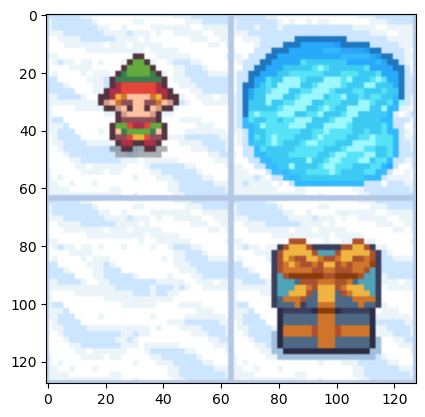

In [11]:
desc=["SH", "FG"]
environment = gym.make('FrozenLake-v1', desc=desc, 
                       render_mode="rgb_array", 
                       is_slippery=False)

# Display the initial state
environment.reset()
rendering = environment.render()
plt.imshow(rendering)

In [15]:
''' 
TO DO
 - Use this cell to investigate the environment
 - Answer the questions below based on what you discover
'''
# START your code here
print("Action space:", environment.action_space)
print("Number of actions:", environment.action_space.n)

print("--------------------------------------------------------------------")

nrows = len(desc)
ncols = len(desc[0])

num_states = nrows * ncols

print("nrows:", nrows)
print("ncols:", ncols)
print("Observation space:", num_states)
# STOP your code here

Action space: Discrete(4)
Number of actions: 4
--------------------------------------------------------------------
nrows: 2
ncols: 2
Observation space: 4


##### **Question:** What is the size of the environment's action space? 

##### **Question:** Based on the documentation, what are the avaialbale actions in the ["Frozen Lake"](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) environment?

##### **Question:** What is the size of the environment's "observation" (state) space? 

## The Random Agent

The random agent selects an action from the action space randomly, and does not learn from experience.

In [16]:
# Define an agent that selects a random move from the action space
class RandomAgent():
    
    # Have the agent learn based on rewards (note: the random agent does not learn)
    def Update(self, state, reward, end):
        pass
    
    # Select a (random) action from the action space
    def PickAction(self, action_space):
        random_action = action_space.sample()
        return random_action

## Reinforcement Learning: Steps and Episodes

The following functions execute the **state -> action -> reward** cycle.
Please review the lecture notes for a more in-depth discussion of **steps** and **episodes** in reinforcement learning.

In this environment, a single **step** moves the agent (elf) from one square to another.

<u>Implementation Hint</u>:
* Read up on the environment's [step](https://gymnasium.farama.org/api/env/#gymnasium.Env.step) function, and pay close attention to the return values

In [26]:
# Define a function to perform a single "step"
def ExecuteStep(agent, environment, step_count, history, renderings):
    
    '''
    TO DO
     - Have the agent pick an action from the environment's action space
     - Perform the "step" based on the selected action
     - Check if the game is over: Is the game "terminated" or "truncated"?
     - Update the agent with rewards and observations. This allows the agent to learn.   
    '''
    # START your code here
    # https://gymnasium.farama.org/introduction/basic_usage/
    action = agent.PickAction(environment.action_space)
    
    observation, reward, terminated, truncated, info = environment.step(action)

    game_over = terminated or truncated

    state = observation

    agent.Update(state, reward, game_over)
    # STOP your code here
    
    '''
    Notes: 
     - Here I am caching some data on each step to help you visualize what is happening over time
     - This book-keeping should not change the behavior of the agent or the environment
    '''
    
    # Log the history
    actions = ['left', 'down', 'right', 'up']
    action_name = actions[action]
    history.append([step_count, action_name, state, reward])
    
    # Cache the rendering
    renderings.append(environment.render())
    
    return state, reward, game_over, step_count + 1

In this environment, an **episode** is concluded when the elf either successfully finds the lost gift or falls in a hole.

In [27]:
# Provide a function to perform an "episode"
def ExecuteEpisode(agent, environment):

    # Reset the environment
    game_over = False
    state, info = environment.reset()
    
    # Initialize the history
    history = []
    history.append(['STEP', 'ACTION', 'STATE', 'REWARD'])
    history.append(['', '', state, ''])
    
    # Renderings for visualizing the game
    renderings = []
    renderings.append(environment.render())
        
    # Iterate until the game is over
    step_count = 0
    reward = 0
    while not game_over:
        
        # Perform one move (step)
        state, reward, game_over, step_count = ExecuteStep(agent, environment, step_count, history, renderings)
            
    # Return the results of this game
    return reward, history, renderings

## Stepping through a game (Random Agent)

In the following cell, we will execute a single game with our random agent. This will help us to better understand the environment and the mechanics of the game. Re-run the cells as many times as you would like to see new games unfold.

<u>Note:</u> If you see a "DeprecationWarning" on the first execution, please feel free to ignore it.

In [28]:
reward, history, renderings = ExecuteEpisode(agent=RandomAgent(), environment=environment)
SummarizeGame(0, reward, history)

Game #0: 0
----  ------  -----  ------
STEP  ACTION  STATE  REWARD
              0
0     up      0      0
1     left    0      0
2     right   1      0
----  ------  -----  ------


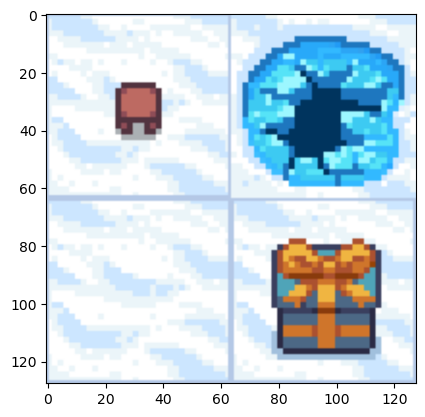

In [29]:
Render(renderings)

## The Q-Learning Agent

The Q-Learning Agent uses the [Q-Learning](https://en.wikipedia.org/wiki/Q-learning) algorithm to learn from experience, and take actions based on what it has learned.

The hallmark reature of this algorithm is the **Q-Table**, an MxN array where:

* M: The number of states in the state space
* N: The number of actions in the action space

Whenever an action is performed from a given state, the Q-value for the corresponding cell is updated according to the resulting reward and various **hyperparameters**. 

* "Learning Rate" (lr): Used to determine how quickly the agent adjusts values in the Q-table.
* "Discount Factor" (df): Used to bound the accumulated rewards.

In order to handle the **exploration vs. exploitation** trade-off, this algorithm is often paired with an $\epsilon$-greedy algorithm, where some percentage of the time, a random action is selected, instead of the optimal action.

* $\epsilon$ (epsilon): Used to configure how frequently a random action should be selected.

In [30]:
# Define an agent that selects a random move from the action space
class QLearningAgent():
    
    # Initialize the agent
    def __init__(self, environment, epsilon, lr=0.7, df=0.95):
        
        # Initialize hyperparameters
        self.epsilon = epsilon
        self.learning_rate = lr
        self.discount_factor = df
        
        # Initialize current state and action
        self.start_state = 0
        self.state = self.start_state
        self.action = -1
        
        '''
        TO DO
         - Initialize the Q-Table to all zeros  
        '''
        self.qtable = None
        # START your code here
        num_states = environment.observation_space.n
        num_actions = environment.action_space.n

        self.qtable = np.zeros((num_states, num_actions))
        # STOP your code here
        
    # Calculates a value that weighs the current reward with a future estimated reward
    def CalculateTemporalDifference(self, reward, future_reward_est, previous_qval):
        # Note: The discount factor can be used to adjust how much the agent relies on current reqard vs future estimated reward
        return reward + (self.discount_factor * future_reward_est) - previous_qval
        
    # Have the agent learn based on rewards
    def Update(self, new_state, reward, end):
        
        '''
        TO DO: 
         - Retrieve the previous Q-Value based on the current state and action
         - Retrieve the expected future reward (the maximum reward available in the new_state row)
         - Calculate the temporal difference (an utility function is provided for this [see: above])
         - Calculate the new Q-Value based on the equation: previous Q-Value + (learning rate * temporal difference)
         - Store the new Q-Value in the Q-Table
        '''
        # START your code here
        # 1
        previous_qval = self.qtable[self.state][self.action]

        # 2
        future_reward = np.max(self.qtable[new_state])

        # 3
        td = self.CalculateTemporalDifference(
            reward,
            future_reward,
            previous_qval
        )

        # 4
        new_qval = previous_qval + (self.learning_rate * td)

        # 5
        self.qtable[self.state][self.action] = new_qval
        # STOP your code here
        
        # If the game is not over, cache the current state, otherwise reset
        self.state = new_state if not end else self.start_state
        
    # Choose the "best known" move (1-epsilon % of the time), otherwise choose a random move
    def EpsilonGreedy(self, action_space):
        
        # See if this falls into the configured % random choice
        random_int = np.random.uniform(0,1)
        random_choice = random_int < self.epsilon
        
        # Also check if there is a "best choice"
        has_best_choice = np.argmax(self.qtable[self.state]) > 0
        
        if not random_choice and has_best_choice:
            # Select the "best" action, based on our Q-table
            action = np.argmax(self.qtable[self.state])
        else:
            # Select a random action
            action = action_space.sample()
        return action
    
    # Pick an action based on the epsilon-greedy algorithm
    def PickAction(self, action_space):
        self.action = self.EpsilonGreedy(action_space)
        return self.action
    
    # Print out the Q-Table
    def Print(self):
        
        # This is hard-coded for the 2x2 environment
        if self.qtable.shape == (4,4):
            table = []
            table.append(['', 'LEFT', 'DOWN', 'RIGHT', 'UP'])
            table.append(['Upper Left', self.qtable[0][0], self.qtable[0][1], self.qtable[0][2], self.qtable[0][3]])
            table.append(['Upper Right', self.qtable[1][0], self.qtable[1][1], self.qtable[1][2], self.qtable[1][3]])
            table.append(['Lower Left', self.qtable[2][0], self.qtable[2][1], self.qtable[2][2], self.qtable[2][3]])
            table.append(['Lower Right', self.qtable[3][0], self.qtable[3][1], self.qtable[3][2], self.qtable[3][3]])
            print(tabulate(table))
        else:
            table = []
            table.append(['', 'LEFT', 'DOWN', 'RIGHT', 'UP'])
            for idx in range(self.qtable.shape[0]):
                table.append(["State {}".format(idx), self.qtable[idx][0], self.qtable[idx][1], self.qtable[idx][2], self.qtable[idx][3]])
            print(tabulate(table))

## Stepping through a game (Q-Learning Agent)

In the following cell, we will execute a single game with our Q-Learning agent. This will help us to better understand the environment and the mechanics of the game. Re-run the cells as many times as you would like to see new games unfold.

<u>Note:</u> If you see a "DeprecationWarning" on the first execution, please feel free to ignore it.

In [31]:
# DO NOT REPEAT THIS CELL
# Once this cell is re-evaluated, the Q-Table will be forgotten and re-initialized to zero
agent = QLearningAgent(environment, epsilon = 0.25)

The following cells can be executed as many times as you would like.
Playing more games with your agent will help it to learn the Q-Table, and it should win a larger percentage of the time.

In [32]:
# Run through a single game
reward, history, renderings = ExecuteEpisode(agent=agent, environment=environment)
    
# Summarize the game
SummarizeGame(0, reward, history)

Game #0: 1
----  ------  -----  ------
STEP  ACTION  STATE  REWARD
              0
0     up      0      0
1     down    2      0
2     down    2      0
3     left    2      0
4     up      0      0
5     down    2      0
6     down    2      0
7     left    2      0
8     down    2      0
9     left    2      0
10    right   3      1
----  ------  -----  ------


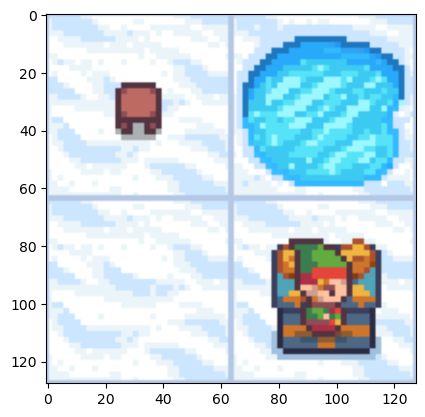

In [33]:
# Render the last game
Render(renderings)

### Examining the Q-table

When we initialized the Q-Table, all the values were zero. The following cell prints out the Q-Table values after training.

Note: You may have to play several games for your agent to learn effectively.

In [34]:
agent.Print()

-----------  ----  ----  -----  ---
             LEFT  DOWN  RIGHT  UP
Upper Left   0.0   0.0   0.0    0.0
Upper Right  0.0   0.0   0.0    0.0
Lower Left   0.0   0.0   0.7    0.0
Lower Right  0.0   0.0   0.0    0.0
-----------  ----  ----  -----  ---


## Working with the Epsilon Hyperparameter
In the cells below, we will be running several games with our agents. The random agent is run as a benchmark for a point of comparison.
The Q-learning agent can be run multiple times with different epsilon values.

In [38]:
NUM_GAMES = 100

In [44]:
# Play N games with the random agent
agent = RandomAgent()
reward_sum = 0
for i in range(0, NUM_GAMES):
    reward, history, renderings = ExecuteEpisode(agent, environment)
    reward_sum += reward

# Summarize the rewards using the given agent
random_agent_average = reward_sum / NUM_GAMES
print("Average reward (Random Agent): {}".format(random_agent_average))

Average reward (Random Agent): 0.25


In [40]:
EPSILON_HIGH = 1.0
EPSILON_MEDIUM = 0.5
EPSILON_LOW = 0.0

In [45]:
'''
TODO: Select the EPSILON value
'''
# START your code here
EPSILON = EPSILON_HIGH
# STOP your code here

# Play N games with the Q-learning agent
agent = QLearningAgent(environment, epsilon = EPSILON)
reward_sum = 0
for i in range(0, NUM_GAMES):
    reward, history, renderings = ExecuteEpisode(agent, environment)
    reward_sum += reward

# Summarize the rewards using the given agent
qlearning_agent_average = reward_sum / NUM_GAMES
print("Average reward (Q-Learning Agent): {}\n".format(qlearning_agent_average))

# Print the Q-Table learned by the agent
print("Q-Table:")
agent.Print()

Average reward (Q-Learning Agent): 0.29

Q-Table:
-----------  ------------------  ------------------  ------------------  ------------------
             LEFT                DOWN                RIGHT               UP
Upper Left   0.9024999999999981  0.9499999999999993  0.0                 0.9024999999999991
Upper Right  0.0                 0.0                 0.0                 0.0
Lower Left   0.9499999999981936  0.9499999999999615  0.9999999999999993  0.9024999999910117
Lower Right  0.0                 0.0                 0.0                 0.0
-----------  ------------------  ------------------  ------------------  ------------------


##### **Question:** Which value of epsilon performed the best?

##### **Question:** How did the EPSILON_HIGH value compare with the random agent?

##### **Question:** Which epsilon value maximizes "Exploration" in the reinforcement learning trade off? Why?

##### **Question:** Which epsilon value maximizes "Exploitation" in the reinforcement learning trade off? Why?

##### **Question:** The rows for Upper Right and Lower Right contain all zeros. Why is that?

##### **Question:** If you start at row 0 in the Q-Table, which column has the largest Q-value? What row would it tell you to transition to next?

## Challenge

Can you make the agent work in a more complex environment? The Frozen Lake environment can be made much larger, and even has options to make the ice slippery!

The cell below has a small amount of boiler-plate to get you started.

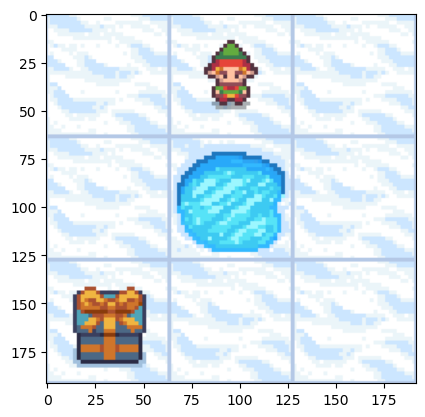

In [46]:
desc=["FSF", "FHF", "GFF"]
environment = gym.make('FrozenLake-v1', desc=desc, render_mode="rgb_array", is_slippery=True)

# Display the initial state
environment.reset()
rendering = environment.render()
plt.imshow(rendering)

In the cell below, you can redefine or add custom versions of the following:
* The agent
* The step execution logic
* The Episode execution logic

In [72]:
# Define an agent that selects a random move from the action space
class QLearningAgent2():
    
    # Initialize the agent
    # CHANGED LEARNING RATE AND DISCOUNT FACTOR FROM OG
    def __init__(self, environment, epsilon, lr=0.5, df=0.01):
        
        # Initialize hyperparameters
        self.epsilon = epsilon
        self.learning_rate = lr
        self.discount_factor = df
        
        # Initialize current state and action
        self.start_state = 0
        self.state = self.start_state
        self.action = -1
        
        num_states = environment.observation_space.n
        num_actions = environment.action_space.n

        self.qtable = np.zeros((num_states, num_actions))
        
    # Calculates a value that weighs the current reward with a future estimated reward
    def CalculateTemporalDifference(self, reward, future_reward_est, previous_qval):
        # Note: The discount factor can be used to adjust how much the agent relies on current reqard vs future estimated reward
        return reward + (self.discount_factor * future_reward_est) - previous_qval
        
    # Have the agent learn based on rewards
    def Update(self, new_state, reward, end):
        previous_qval = self.qtable[self.state][self.action]
        future_reward = np.max(self.qtable[new_state])

        td = self.CalculateTemporalDifference(
            reward,
            future_reward,
            previous_qval
        )

        new_qval = previous_qval + (self.learning_rate * td)
        self.qtable[self.state][self.action] = new_qval
        # STOP your code here
        
        # If the game is not over, cache the current state, otherwise reset
        self.state = new_state if not end else self.start_state
        
    # Choose the "best known" move (1-epsilon % of the time), otherwise choose a random move
    def EpsilonGreedy(self, action_space):
        
        # See if this falls into the configured % random choice
        random_int = np.random.uniform(0,1)
        random_choice = random_int < self.epsilon
        
        # Also check if there is a "best choice"
        has_best_choice = np.argmax(self.qtable[self.state]) > 0
        
        if not random_choice and has_best_choice:
            # Select the "best" action, based on our Q-table
            action = np.argmax(self.qtable[self.state])
        else:
            # Select a random action
            action = action_space.sample()
        return action
    
    # Pick an action based on the epsilon-greedy algorithm
    def PickAction(self, action_space):
        self.action = self.EpsilonGreedy(action_space)
        return self.action
    
    # Print out the Q-Table
    def Print(self):
        table = []
        table.append(['', 'LEFT', 'DOWN', 'RIGHT', 'UP'])
        for idx in range(self.qtable.shape[0]):
            table.append(["State {}".format(idx), self.qtable[idx][0], self.qtable[idx][1], self.qtable[idx][2], self.qtable[idx][3]])
        print(tabulate(table))

The following cell will use the specified agent and specified execution logic to train on the new environment.

In [73]:
# START your code here
EPSILON = EPSILON_LOW
agent = QLearningAgent2(environment, epsilon = EPSILON) # You can replace this with a custom agent
episode_execution = ExecuteEpisode # You can replace this with a custom execution logic
# STOP your code here

# Play N games with the Q-learning agent
reward_sum = 0
for i in range(0, NUM_GAMES):
    reward, history, renderings = episode_execution(agent, environment)
    reward_sum += reward

# Summarize the rewards using the given agent
qlearning_agent_average = reward_sum / NUM_GAMES
print("Average reward (Q-Learning Agent): {}\n".format(qlearning_agent_average))

# Print the Q-Table learned by the agent
print("Q-Table:")
agent.Print()

Average reward (Q-Learning Agent): 0.15

Q-Table:
-------  ---------------------  ----------------------  ---------------------  ---------------------
         LEFT                   DOWN                    RIGHT                  UP
State 0  9.022917342228442e-06  2.03444046959949e-05    9.636116295617768e-06  8.090936040105082e-07
State 1  0.0                    1.1754627583047441e-07  0.0                    0.0
State 2  0.0                    0.0                     0.0                    6.541962138652472e-10
State 3  0.0                    0.515448236240043       0.0                    0.0
State 4  0.0                    0.0                     0.0                    0.0
State 5  0.0                    0.0                     0.0                    0.0
State 6  0.0                    0.0                     0.0                    0.0
State 7  0.0                    0.0                     0.0                    0.0
State 8  0.0                    0.0                     0.0        

##### **Question:** Did your agent learn the shortest path to the gift? How can you tell?

##### **Question:** What other strategies could you use to improve your agent's performance?